In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shanegerami","key":"0c32ffffd343776b8cd094b718ef52a5"}'}

In [2]:
!mkdir -p ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d mathchi/online-retail-ii-data-set-from-ml-repository

 89% 51.0M/57.5M [00:01<00:00, 36.2MB/s]
100% 57.5M/57.5M [00:01<00:00, 32.2MB/s]


In [6]:
!unzip rfm.zip

Archive:  rfm.zip
  inflating: Year 2009-2010.csv      
  inflating: Year 2010-2011.csv      
  inflating: online_retail_II.xlsx   


In [7]:
import pandas as pd

df = pd.read_excel('online_retail_II.xlsx', sheet_name="Year 2010-2011")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
df.describe()

,Quantity,Price,Customer ID
count,541910.000000,541910.000000,406830.000000
mean,9.552234,4.611138,15287.684160
std,218.080957,96.759765,1713.603074
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
len(df)

541910

In [10]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [11]:
df.dropna(inplace=True)
len(df)

406830

In [12]:
#number of unique items
df["Description"].nunique()

3896

In [13]:
#Remove the canceled transactions from the dataset
df = df[~df["Invoice"].str.contains("C", na=False)]

In [14]:
len(df)

397925

In [15]:
#creating the total price column
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [16]:
import datetime as dt

# Calculate the current date (you can adjust this as needed)
today_date = dt.datetime(2011, 12, 11)

# Group by 'Customer ID' and perform aggregations
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda date: (today_date - date.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency (count unique invoices)
    'TotalPrice': 'sum'  # Monetary (sum of TotalPrice)
})

# Rename the columns for clarity
rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,1,77183.60
12347.0,3,7,4310.00
12348.0,76,4,1797.24
12349.0,19,1,1757.55
12350.0,311,1,334.40
...,...,...,...
18280.0,278,1,180.60
18281.0,181,1,80.82
18282.0,8,2,178.05


In [17]:
# Normalize the values (e.g., using Min-Max scaling)
rfm['Recency_Norm'] = (rfm['Recency'] - rfm['Recency'].min()) / (rfm['Recency'].max() - rfm['Recency'].min())
rfm['Frequency_Norm'] = (rfm['Frequency'] - rfm['Frequency'].min()) / (rfm['Frequency'].max() - rfm['Frequency'].min())
rfm['Monetary_Norm'] = (rfm['Monetary'] - rfm['Monetary'].min()) / (rfm['Monetary'].max() - rfm['Monetary'].min())

# Define weights for each dimension
recency_weight = 0.45
frequency_weight = 0.35
monetary_weight = 0.20

# Calculate individual scores
rfm['Recency_Score'] = 1 - rfm['Recency_Norm']
rfm['Frequency_Score'] = rfm['Frequency_Norm']
rfm['Monetary_Score'] = rfm['Monetary_Norm']

# Calculate the overall RFM score
rfm['RFM_Score'] = (rfm['Recency_Score'] * recency_weight + rfm['Frequency_Score'] * frequency_weight + rfm['Monetary_Score'] * monetary_weight)

rfm.head()


,Recency,Frequency,Monetary,Recency_Norm,Frequency_Norm,Monetary_Norm,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score
Customer ID,,,,,,,,,,
12346.0,326,1,77183.60,0.871314,0.000000,0.275453,0.128686,0.000000,0.275453,0.112999
12347.0,3,7,4310.00,0.005362,0.028708,0.015382,0.994638,0.028708,0.015382,0.460711
12348.0,76,4,1797.24,0.201072,0.014354,0.006414,0.798928,0.014354,0.006414,0.365824
12349.0,19,1,1757.55,0.048257,0.000000,0.006272,0.951743,0.000000,0.006272,0.429539
12350.0,311,1,334.40,0.831099,0.000000,0.001193,0.168901,0.000000,0.001193,0.076244


In [18]:
rfm['Segment'] = 'Need Attention'  # Start by assigning all customers to the 'Need Attention' segment

# Define segmentation criteria
segment_criteria = {
    'Champions': (rfm['Recency_Score'] >= 0.7) & (rfm['Frequency_Score'] >= 0.7) & (rfm['Monetary_Score'] >= 0.7),
    'Loyal Customers': (rfm['Recency_Score'] >= 0.5) & (rfm['Frequency_Score'] >= 0.5),
    'Potential Loyalists': (rfm['Recency_Score'] >= 0.5) & (rfm['Frequency_Score'] >= 0.3),
    'At-Risk Customers': (rfm['Recency_Score'] < 0.3) | (rfm['Frequency_Score'] < 0.3),
    'New Customers': (rfm['Recency_Score'] >= 0.6) & (rfm['Frequency_Score'] < 0.2),
    'Lost Customers': (rfm['Recency_Score'] < 0.3) & (rfm['Frequency_Score'] < 0.3),
}

# Apply the segmentation criteria to update the 'Segment' column
for segment, criteria in segment_criteria.items():
    rfm['Segment'] = rfm['Segment'].where(~criteria, segment)

In [19]:
rfm.head()

,Recency,Frequency,Monetary,Recency_Norm,Frequency_Norm,Monetary_Norm,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,Segment
Customer ID,,,,,,,,,,,
12346.0,326,1,77183.60,0.871314,0.000000,0.275453,0.128686,0.000000,0.275453,0.112999,Lost Customers
12347.0,3,7,4310.00,0.005362,0.028708,0.015382,0.994638,0.028708,0.015382,0.460711,New Customers
12348.0,76,4,1797.24,0.201072,0.014354,0.006414,0.798928,0.014354,0.006414,0.365824,New Customers
12349.0,19,1,1757.55,0.048257,0.000000,0.006272,0.951743,0.000000,0.006272,0.429539,New Customers
12350.0,311,1,334.40,0.831099,0.000000,0.001193,0.168901,0.000000,0.001193,0.076244,Lost Customers


In [20]:
#Calculating the CLV (Customer life time value)

In [21]:
rfm['Net_Revenue'] = rfm['Monetary'] * rfm['Frequency']

In [22]:
n = 2  # Adjust the time period as needed

discount_rate = 0.10  # 10%

# Calculate CLV using a list comprehension
rfm['CLV'] = 1/2 * ((rfm['Net_Revenue'] / (1 + discount_rate)**1) + (rfm['Net_Revenue'] / (1 + discount_rate)**2))

rfm

,Recency,Frequency,Monetary,Recency_Norm,Frequency_Norm,Monetary_Norm,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,Segment,Net_Revenue,CLV
Customer ID,,,,,,,,,,,,,
12346.0,326,1,77183.60,0.871314,0.000000,0.275453,0.128686,0.000000,0.275453,0.112999,Lost Customers,77183.60,66977.504132
12347.0,3,7,4310.00,0.005362,0.028708,0.015382,0.994638,0.028708,0.015382,0.460711,New Customers,30170.00,26180.578512
12348.0,76,4,1797.24,0.201072,0.014354,0.006414,0.798928,0.014354,0.006414,0.365824,New Customers,7188.96,6238.353719
12349.0,19,1,1757.55,0.048257,0.000000,0.006272,0.951743,0.000000,0.006272,0.429539,New Customers,1757.55,1525.146694
12350.0,311,1,334.40,0.831099,0.000000,0.001193,0.168901,0.000000,0.001193,0.076244,Lost Customers,334.40,290.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,278,1,180.60,0.742627,0.000000,0.000645,0.257373,0.000000,0.000645,0.115947,Lost Customers,180.60,156.719008
18281.0,181,1,80.82,0.482574,0.000000,0.000288,0.517426,0.000000,0.000288,0.232900,At-Risk Customers,80.82,70.133058
18282.0,8,2,178.05,0.018767,0.004785,0.000635,0.981233,0.004785,0.000635,0.443357,New Customers,356.10,309.012397


In [23]:
rfm[["Segment", "Recency","Frequency","Monetary", "CLV"]].groupby("Segment").agg(["mean","count","max"]).round()

Recency            Frequency            Monetary        \
                       mean count  max      mean count  max     mean count   
Segment                                                                      
At-Risk Customers     200.0   615  262       3.0   615   63   2384.0   615   
Lost Customers        316.0   440  374       1.0   440   34    579.0   440   
New Customers          43.0  3276  150       5.0  3276   41   1999.0  3276   
Potential Loyalists     2.0     8    4     122.0     8  210  80210.0     8   

                                     CLV                    
                          max       mean count         max  
Segment                                                     
At-Risk Customers    259657.0    80172.0   615  13519347.0  
Lost Customers        77184.0     1169.0   440    159063.0  
New Customers        168472.0    19070.0  3276   2449653.0  
Potential Loyalists  280206.0  8150198.0     8  25086181.0


- **Segments:**
  - **At-Risk Customers:** These customers have a mean recency of 200 days, a mean frequency of 3, and a mean monetary value of 2384. The segment includes 615 customers with varying counts for frequency and monetary values.
  - **Lost Customers:** This segment has a higher mean recency of 316 days, a lower mean frequency of 1, and a lower mean monetary value of 579. The segment includes 440 customers.
  - **New Customers:** This segment has a low mean recency of 43 days, a high mean frequency of 5, and a high mean monetary value of 1999. The segment is the largest with 3276 customers.
  - **Potential Loyalists:** This segment has a very low mean recency of 2 days, a high mean frequency of 122, and a very high mean monetary value of 80210. The segment includes only 8 customers.

- **Insights:**
  1. **At-Risk Customers:**
     - These customers have made recent purchases but have a relatively low frequency and monetary value.
     - The business might consider targeted marketing or retention strategies to increase the frequency and monetary value of this segment.

  2. **Lost Customers:**
     - This segment has customers with a higher recency, indicating they haven't made a purchase in a while.
     - Efforts should be made to understand why these customers have lapsed and consider reactivation campaigns.

  3. **New Customers:**
     - The large number of new customers is promising.
     - The business should focus on converting these new customers into loyal ones by encouraging repeat purchases and increasing their monetary value.

  4. **Potential Loyalists:**
     - This small segment has customers with very recent and frequent high-value purchases.
     - Special attention should be given to this segment, potentially through loyalty programs or personalized offerings to solidify their loyalty.

- **Suggestions:**
  - **Customer Retention:** For At-Risk and Lost Customers, implement retention strategies such as targeted promotions, reactivation campaigns, and personalized communications to encourage repeat purchases.
  - **New Customer Engagement:** Focus on engagement strategies for New Customers to convert them into regular, higher-value customers.
  - **Loyalty Programs:** Consider implementing or enhancing loyalty programs, especially for the Potential Loyalists, to strengthen their loyalty to the brand.
  




In [ ]:
# # Merge the RFM values back into the original dataset
# df = pd.merge(df, rfm, left_on='Customer ID', right_index=True)

# df.head()

In [ ]:
#next steps:

#decide which columns you want to add to df
#use ml models to predict the classification column as the target

In [ ]:
# ML classifying

In [ ]:
#Using all features:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

target_variable = 'Segment'

# Select features and target variable
features = ['Recency', 'Frequency', 'Monetary', 'Recency_Norm', 'Frequency_Norm', 'Monetary_Norm', 'Recency_Score', 'Frequency_Score', 'Monetary_Score', 'RFM_Score', 'Net_Revenue', 'CLV']
X = rfm[features]
y = rfm[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=y_train.unique(), y=y_train)
class_weight_dict = dict(zip(y_train.unique(), class_weights))

# Initialize the Random Forest Classifier with class weights
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.00

Classification Report:
                      precision    recall  f1-score   support

  At-Risk Customers       1.00      1.00      1.00       116
     Lost Customers       1.00      1.00      1.00        93
      New Customers       1.00      1.00      1.00       657
Potential Loyalists       1.00      1.00      1.00         2

           accuracy                           1.00       868
          macro avg       1.00      1.00      1.00       868
       weighted avg       1.00      1.00      1.00       868



In [46]:
#There is a high chance of overfitting

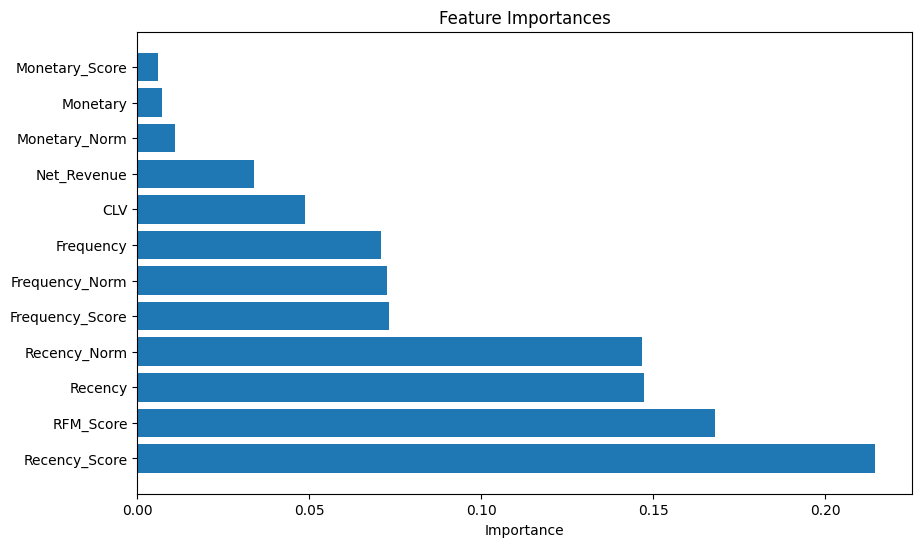

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# Assuming 'Segment' is the target variable
target_variable = 'Segment'

# Select features and target variable
features = ['Recency', 'Frequency', 'Monetary', 'Recency_Norm', 'Frequency_Norm', 'Monetary_Norm', 'Recency_Score', 'Frequency_Score', 'Monetary_Score', 'RFM_Score', 'Net_Revenue', 'CLV']
X = rfm[features]
y = rfm[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=y_train.unique(), y=y_train)
class_weight_dict = dict(zip(y_train.unique(), class_weights))

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)

# Train the model
clf.fit(X_train, y_train)

# Get feature importances
feature_importances = clf.feature_importances_

# Create a DataFrame to visualize feature importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()


In [33]:
#OverSampling

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import RandomOverSampler

target_variable = 'Segment'

# Select features and target variable
features = ['Recency_Norm', 'Frequency_Norm', 'Monetary_Norm']
X = rfm[features]
y = rfm[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply oversampling
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.00

Classification Report:
                      precision    recall  f1-score   support

  At-Risk Customers       1.00      1.00      1.00       116
     Lost Customers       1.00      1.00      1.00        93
      New Customers       1.00      1.00      1.00       657
Potential Loyalists       1.00      1.00      1.00         2

           accuracy                           1.00       868
          macro avg       1.00      1.00      1.00       868
       weighted avg       1.00      1.00      1.00       868



In [34]:
print(len(X_train))
print(len(X_train_resampled))

3471
10476


In [30]:
#UnderSampling

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.under_sampling import RandomUnderSampler


target_variable = 'Segment'

# Select features and target variable
features = ['Recency_Norm', 'Frequency_Norm', 'Monetary_Norm']
X = rfm[features]
y = rfm[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply undersampling
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.96

Classification Report:
                      precision    recall  f1-score   support

  At-Risk Customers       0.79      0.92      0.85       116
     Lost Customers       0.94      0.98      0.96        93
      New Customers       1.00      0.96      0.98       657
Potential Loyalists       0.40      1.00      0.57         2

           accuracy                           0.96       868
          macro avg       0.78      0.96      0.84       868
       weighted avg       0.96      0.96      0.96       868



In [32]:
print(len(X_train))
print(len(X_train_resampled))

3471
24


In [43]:
#mixed:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Assuming 'Segment' is the target variable
target_variable = 'Segment'

# Select features and target variable
features = ['Recency_Norm', 'Frequency_Norm', 'Monetary_Norm']
X = rfm[features]
y = rfm[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the resampling strategy
undersampler = RandomUnderSampler(sampling_strategy='majority')
oversampler = RandomOverSampler(sampling_strategy='minority')

# Create the pipeline
pipeline = Pipeline([
    ('under', undersampler),
    ('over', oversampler)
])

# Apply resampling to the training data
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)


# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.86

Classification Report:
                      precision    recall  f1-score   support

  At-Risk Customers       0.49      1.00      0.65       116
     Lost Customers       1.00      1.00      1.00        93
      New Customers       1.00      0.81      0.90       657
Potential Loyalists       1.00      1.00      1.00         2

           accuracy                           0.86       868
          macro avg       0.87      0.95      0.89       868
       weighted avg       0.93      0.86      0.88       868



In [37]:
print(len(X_train))
print(len(X_train_resampled))

3471
1351


In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Assuming 'Segment' is the target variable
target_variable = 'Segment'

# Select features and target variable
features = ['Recency_Norm', 'Frequency_Norm', 'Monetary_Norm']
X = rfm[features]
y = rfm[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the resampling strategy
undersampler = RandomUnderSampler(sampling_strategy='majority')
oversampler = RandomOverSampler(sampling_strategy='minority')

# Create the pipeline
pipeline = Pipeline([
    ('under', undersampler),
    ('over', oversampler)
])

# Apply resampling to the training data
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

# Fit the model using GridSearchCV with resampled data
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Get the best model from GridSearchCV
best_clf = grid_search.best_estimator_

# Evaluate the best model using cross-validation
cv_accuracy = cross_val_score(best_clf, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print("Cross-validated Accuracy:", f"{cv_accuracy.mean():.2f} (+/- {cv_accuracy.std():.2f})")

# Make predictions on the test set
y_pred = best_clf.predict(X_test)

# Evaluate the best model on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")

# Display classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Best Parameters: {'max_depth': None, 'n_estimators': 100}
Cross-validated Accuracy: 1.00 (+/- 0.00)

Accuracy: 0.66

Classification Report:
                      precision    recall  f1-score   support

  At-Risk Customers       0.28      0.99      0.44       116
     Lost Customers       1.00      1.00      1.00        93
      New Customers       1.00      0.55      0.71       657
Potential Loyalists       0.67      1.00      0.80         2

           accuracy                           0.66       868
          macro avg       0.74      0.89      0.74       868
       weighted avg       0.90      0.66      0.71       868



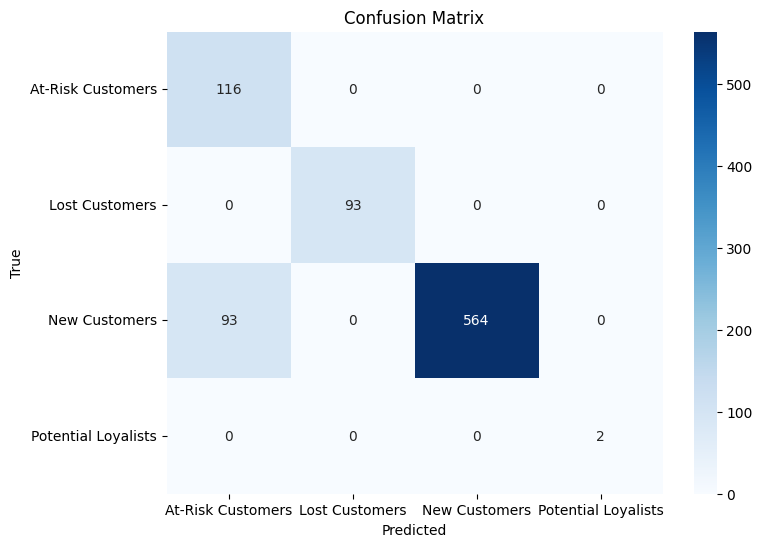

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_clf.classes_, yticklabels=best_clf.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()